# Introduction

This notebook compares the test set performance of classifiers using term list scores based on the data-driven, RDoC, and DSM frameworks.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities, evaluation
from style import style 

%matplotlib inline

## Input parameters

In [2]:
clf = "lr"
n_iter = 1000 # Number of iterations for bootstrap distributions

In [3]:
frameworks = ["data-driven_k09", "data-driven", "rdoc", "dsm"]
names = {"data-driven_k09": "", "data-driven": "", "rdoc": "", "dsm": ""}
metrics = ["rocauc", "f1"]
directions = ["forward", "reverse"]

## Bootstrap distributions

In [4]:
obs, boot, null = {}, {}, {}
for fw in frameworks:
    obs[fw], boot[fw], null[fw] = {"name": names[fw]}, {"name": names[fw]}, {"name": names[fw]}
    for m in metrics:
        obs[fw][m], boot[fw][m], null[fw][m] = {}, {}, {}
        for d in directions:
            boot_file = "logistic_regression/data/{}_boot_{}_{}_{}iter.csv".format(m, fw, d, n_iter)
            boot[fw][m][d] = pd.read_csv(boot_file, index_col=0, header=0)
            null_file = "logistic_regression/data/{}_null_{}_{}_{}iter.csv".format(m, fw, d, n_iter)
            null[fw][m][d] = pd.read_csv(null_file, index_col=0, header=0)
            obs_file = "logistic_regression/data/{}_obs_{}_{}.csv".format(m, fw, d)
            obs[fw][m][d] = pd.read_csv(obs_file, index_col=0, header=None)

# Perform comparison tests

Is the mean of fw<sub>i</sub> greater than the mean of fw<sub>j</sub>?

In [5]:
from statsmodels.stats.multitest import multipletests

In [6]:
fdr, sig = {}, {}
for metric in metrics:
    fdr[metric], sig[metric] = {}, {}
    for direction in directions:
        
        p = np.empty((len(frameworks), len(frameworks)))
        for i, fw_i in enumerate(frameworks):
            for j, fw_j in enumerate(frameworks):
                boot_i = np.mean(boot[fw_i][metric][direction], axis=0)
                boot_j = np.mean(boot[fw_j][metric][direction], axis=0)
                p[i,j] = np.sum((boot_i - boot_j) <= 0.0) / float(n_iter)
        
        fdr_md = multipletests(p.ravel(), method="fdr_bh")[1].reshape(p.shape)
        fdr_md = pd.DataFrame(fdr_md, index=frameworks, columns=frameworks)
        fdr[metric][direction] = fdr_md

# Plot evaluation metrics

In [7]:
def plot_framework_comparison(metric, direction, boot, n_iter=1000,
                              dx=0.38, ylim=[0.4,0.65], yticks=[], font=style.font):
    
    import matplotlib.pyplot as plt
    from matplotlib import font_manager, rcParams

    font_prop = font_manager.FontProperties(fname=font, size=18)
    rcParams["axes.linewidth"] = 1.5
    
    fig = plt.figure(figsize=(1.6,2.1))#plt.figure(figsize=(2.6,3.2))
    ax = fig.add_axes([0,0,1,1])

    i = 0
    labels = []
    for fw, dist in boot.items():
        labels.append(dist["name"])
        dist = dist[metric][direction]
        dist_avg = np.mean(dist, axis=0)
        macro_avg = np.mean(dist_avg)
        plt.plot([i-dx, i+dx], [macro_avg, macro_avg], 
                 c="gray", alpha=1, lw=2, zorder=-1)
        v = ax.violinplot(sorted(dist_avg), positions=[i], 
                          showmeans=False, showmedians=False, widths=0.85)
        for pc in v["bodies"]:
            pc.set_facecolor("gray")
            pc.set_edgecolor("gray")
            pc.set_linewidth(2)
            pc.set_alpha(0.5)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        i += 1

    ax.set_xticks(range(len(boot.keys())))
    ax.set_xticklabels(labels, rotation=60, ha="right")
    plt.xticks(fontproperties=font_prop)
    plt.yticks(yticks, fontproperties=font_prop)
    plt.xlim([-0.75, len(boot.keys())-0.25])
    plt.ylim(ylim)
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.yaxis.set_tick_params(width=1.5, length=7)
    plt.savefig("logistic_regression/figures/{}_{}_{}iter_k09.png".format(metric, direction, n_iter), 
                dpi=250, bbox_inches="tight")
    plt.show()

## ROC-AUC

----------------------------------------
		FORWARD
----------------------------------------
                 data-driven_k09  data-driven  rdoc  dsm
data-driven_k09              1.0     0.021333   0.0  0.0
data-driven                  1.0     1.000000   0.0  0.0
rdoc                         1.0     1.000000   1.0  0.0
dsm                          1.0     1.000000   1.0  1.0



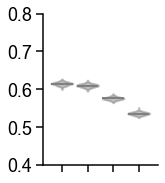

----------------------------------------
		REVERSE
----------------------------------------
                 data-driven_k09  data-driven  rdoc    dsm
data-driven_k09         1.000000          1.0   0.0  0.000
data-driven             0.085333          1.0   0.0  0.000
rdoc                    1.000000          1.0   1.0  0.016
dsm                     1.000000          1.0   1.0  1.000



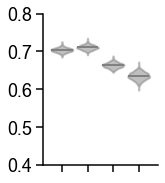

In [8]:
metric = "rocauc"
for direction in directions:
    print("-"*40 + "\n\t\t" + direction.upper() + "\n" + "-"*40)
    print(fdr[metric][direction])
    print("")
    plot_framework_comparison(metric, direction, boot, n_iter=n_iter, 
                              ylim=[0.4,0.8], 
                              yticks=[0.4,0.5,0.6,0.7,0.8])

## F1 score

----------------------------------------
		FORWARD
----------------------------------------
                 data-driven_k09  data-driven  rdoc  dsm
data-driven_k09              1.0          0.0   0.0  0.0
data-driven                  1.0          1.0   0.0  0.0
rdoc                         1.0          1.0   1.0  0.0
dsm                          1.0          1.0   1.0  1.0



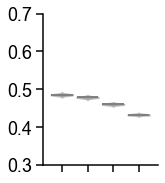

----------------------------------------
		REVERSE
----------------------------------------
                 data-driven_k09  data-driven  rdoc  dsm
data-driven_k09            1.000          1.0   0.0  0.0
data-driven                0.152          1.0   0.0  0.0
rdoc                       1.000          1.0   1.0  0.0
dsm                        1.000          1.0   1.0  1.0



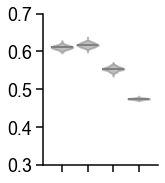

In [9]:
metric = "f1"
for direction in directions:
    print("-"*40 + "\n\t\t" + direction.upper() + "\n" + "-"*40)
    print(fdr[metric][direction])
    print("")
    plot_framework_comparison(metric, direction, boot, n_iter=n_iter, 
                              ylim=[0.3,0.7], yticks=[0.3,0.4,0.5,0.6,0.7])